#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/desafio-de-prediccion-de-precios-de-portatiles

## Librerias

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

## MiniEDA

In [2]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
target = 'Price_euros'

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [5]:
df.head(5)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


In [6]:
df_test.head(5)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,181,1098,HP,Spectre x360,Ultrabook,13.3,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.3kg
1,708,330,Acer,Aspire 5,Notebook,15.6,1366x768,AMD A12-Series 9720P 2.7GHz,8GB,256GB SSD,AMD Radeon RX 540,Windows 10,2.2kg
2,862,1260,Acer,Aspire ES1-572,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,500GB HDD,Intel HD Graphics 520,Linux,2.4kg
3,1064,1137,HP,EliteBook 1040,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.43kg
4,702,1015,HP,ENVY -,Notebook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.34kg


Se trata de un problema supervisado de regresión, ya que queremos predecir un valor numérico continuo: el precio (Prices_euros).

No tenemos valores NULL.

### Variables Categóricas

Tenemos muchas variables categóricas. Un par de ellas las podemos pasar a numéricas:

In [7]:
# Eliminamos "GB" de la columna Ram y convertimos a numérico
df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)
df_test['Ram'] = df_test['Ram'].str.replace('GB', '').astype(int)

In [8]:
# Eliminamos "kg" de la columna Weight y convertimos a numérico
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)
df_test['Weight'] = df_test['Weight'].str.replace('kg', '').astype(float)

Nos deshacemos de columnas no útiles:

In [9]:
# Eliminamos la columna id
df = df.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

Ejecutamos nuevamente info:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    object 
 2   Product           912 non-null    object 
 3   TypeName          912 non-null    object 
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    object 
 6   Cpu               912 non-null    object 
 7   Ram               912 non-null    int32  
 8   Memory            912 non-null    object 
 9   Gpu               912 non-null    object 
 10  OpSys             912 non-null    object 
 11  Weight            912 non-null    float64
 12  Price_euros       912 non-null    float64
dtypes: float64(3), int32(1), int64(1), object(8)
memory usage: 89.2+ KB


Analicemos más en profundidad el resto de variables categóricas.

In [11]:
#Variable Company

df['Company'].value_counts()

Company
Lenovo       208
Dell         207
HP           189
Asus         108
Acer          75
Toshiba       37
MSI           34
Apple         17
Mediacom       7
Razer          6
Samsung        6
Fujitsu        3
Microsoft      3
Vero           3
Xiaomi         3
Google         2
Chuwi          2
LG             1
Huawei         1
Name: count, dtype: int64

Resolución: son bastantes categorías, pero se podrían mantener tal y como están. Es un número factible de categorías.

In [12]:
#Variable Product

df['Product'].value_counts()

Product
Inspiron 3567                                21
XPS 13                                       20
250 G6                                       19
Vostro 3568                                  16
Inspiron 5570                                11
                                             ..
Elitebook Folio                               1
Q304UA-BHI5T11 (i5-7200U/6GB/1TB/FHD/W10)     1
ThinkPad T470p                                1
V310-15IKB (i5-7200U/4GB/1TB/No               1
Portege Z30-C-16H                             1
Name: count, Length: 475, dtype: int64

Resolucion: agruparemos los menos frecuentes en una categoría Otros.

In [13]:
umbral = 6 

dfproduct_counts = df['Product'].value_counts()
# Definimos la función para agrupar los productos
def df_agrupar_productos(product):
    if dfproduct_counts[product] >= umbral:
        return product
    else:
        return 'Other'
    
dftestproduct_counts = df_test['Product'].value_counts()
# Definimos la función para agrupar los productos
def df_test_agrupar_productos(product):
    if dftestproduct_counts[product] >= umbral:
        return product
    else:
        return 'Other'

In [14]:
# Aplicamos la función a la columna 'Product'
df['Product'] = df['Product'].apply(df_agrupar_productos)
df_test['Product'] = df_test['Product'].apply(df_test_agrupar_productos)

df['Product'].value_counts()


Product
Other                 653
Inspiron 3567          21
XPS 13                 20
250 G6                 19
Vostro 3568            16
ProBook 450            11
Inspiron 5570          11
Legion Y520-15IKBN     11
Inspiron 7567          10
Inspiron 5567          10
Satellite Pro          10
Alienware 17           10
Aspire 3               10
EliteBook 840           9
ThinkPad X1             9
MacBook Pro             8
EliteBook 850           8
XPS 15                  8
ProBook 470             7
EliteBook 820           7
IdeaPad 320-15ISK       7
Vostro 5568             7
Probook 440             6
Inspiron 7577           6
Inspiron 3576           6
Inspiron 3552           6
MacBook 12"             6
Name: count, dtype: int64

Perdemos mucha visibilidad de los Productos, y bajo mi punto de vista es importante saber el producto para predecir el precio final. Pero opto por reducir la dimensionalidad en el modelo.

In [15]:
#Variable TypeName

df['TypeName'].value_counts()

TypeName
Notebook              522
Gaming                138
Ultrabook             135
2 in 1 Convertible     85
Workstation            18
Netbook                14
Name: count, dtype: int64

Resolucion: la mantenemos como es, sin cambios.

In [16]:
#Variable ScreenResolution

df['ScreenResolution'].value_counts()

ScreenResolution
Full HD 1920x1080                                346
1366x768                                         208
IPS Panel Full HD 1920x1080                      163
IPS Panel Full HD / Touchscreen 1920x1080         37
Full HD / Touchscreen 1920x1080                   32
Touchscreen 1366x768                              15
1600x900                                          11
IPS Panel 4K Ultra HD 3840x2160                   10
4K Ultra HD / Touchscreen 3840x2160                8
Quad HD+ / Touchscreen 3200x1800                   8
IPS Panel 4K Ultra HD / Touchscreen 3840x2160      8
IPS Panel Retina Display 2304x1440                 6
IPS Panel Retina Display 2560x1600                 5
IPS Panel 1366x768                                 5
4K Ultra HD 3840x2160                              5
IPS Panel Touchscreen 1920x1200                    4
Touchscreen 2560x1440                              4
IPS Panel Quad HD+ / Touchscreen 3200x1800         4
IPS Panel Touchscreen 2560x14

Resolución: agruparemos en resoluciones comunes para reducir dimensionalidad. 

Los estándares más comunes para laptops y monitores suelen ser:

- HD (1366x768): laptops de gama baja y media.
- Full HD (1920x1080): laptops de gama media y alta.
- 4K (3840x2160): laptops de gama alta y monitores avanzados.

In [17]:
def agrupar_screen_resolution(resolution):
    if '1366x768' in resolution:
        return 'HD'
    elif '1920x1080' in resolution:
        return 'Full HD'
    elif '3840x2160' in resolution:
        return '4K'
    else:
        return 'Other'

In [18]:
# Agrupación de 'ScreenResolution'
df['ScreenResolution'] = df['ScreenResolution'].apply(agrupar_screen_resolution)

In [19]:
df_test['ScreenResolution'] = df_test['ScreenResolution'].apply(agrupar_screen_resolution)

In [20]:
df['ScreenResolution'].value_counts()

ScreenResolution
Full HD    582
HD         229
Other       67
4K          34
Name: count, dtype: int64

In [21]:
#Variable Cpu

df['Cpu'].value_counts()

Cpu
Intel Core i5 7200U 2.5GHz     142
Intel Core i7 7700HQ 2.8GHz    102
Intel Core i7 7500U 2.7GHz      88
Intel Core i5 8250U 1.6GHz      54
Intel Core i5 6200U 2.3GHz      51
                              ... 
Intel Core i7 7660U 2.5GHz       1
AMD E-Series E2-9000 2.2GHz      1
Intel Core i3 6006U 2.2GHz       1
Intel Core i7 2.8GHz             1
AMD E-Series 9000 2.2GHz         1
Name: count, Length: 104, dtype: int64

Resolución: Agrupamos por familia de CPU.

In [22]:
# Agrupación de 'Cpu'
def agrupar_cpu(cpu):
    if 'i7' in cpu:
        return 'i7'
    elif 'i5' in cpu:
        return 'i5'
    elif 'i3' in cpu:
        return 'i3'
    elif 'Pentium' in cpu:
        return 'Pentium'
    else:
        return 'Other'

In [23]:
df['Cpu'] = df['Cpu'].apply(agrupar_cpu)

In [24]:
df_test['Cpu'] = df_test['Cpu'].apply(agrupar_cpu)

In [25]:
df['Cpu'].value_counts()

Cpu
i7         351
i5         305
Other      131
i3          99
Pentium     26
Name: count, dtype: int64

In [26]:
#Variable Memory

df['Memory'].value_counts()

Memory
256GB SSD                        293
1TB HDD                          150
500GB HDD                        100
512GB SSD                         75
128GB SSD +  1TB HDD              61
128GB SSD                         56
256GB SSD +  1TB HDD              52
32GB Flash Storage                27
64GB Flash Storage                11
2TB HDD                           11
512GB SSD +  1TB HDD              10
1TB SSD                            9
1.0TB Hybrid                       7
256GB Flash Storage                7
32GB SSD                           5
180GB SSD                          5
256GB SSD +  2TB HDD               4
16GB Flash Storage                 4
16GB SSD                           3
256GB SSD +  500GB HDD             2
1TB SSD +  1TB HDD                 2
128GB Flash Storage                2
512GB SSD +  2TB HDD               2
512GB Flash Storage                2
1.0TB HDD                          1
32GB HDD                           1
128GB SSD +  2TB HDD           

Resolución: Agrupamos por tipo de almacenamiento (HDD, SSD, híbrido).

In [27]:
# Agrupación de 'Memory'

def agrupar_memory(memory):
    if 'HDD' in memory and 'SSD' not in memory:
        return 'HDD'
    elif 'SSD' in memory and 'HDD' not in memory:
        return 'SSD'
    elif 'HDD' in memory and 'SSD' in memory:
        return 'Hybrid'
    else:
        return 'Other'

In [28]:
df['Memory'] = df['Memory'].apply(agrupar_memory)

In [29]:
df_test['Memory'] = df_test['Memory'].apply(agrupar_memory)

In [30]:
#Variable GPU

df['Gpu'].value_counts()

Gpu
Intel HD Graphics 620      199
Intel HD Graphics 520      138
Intel UHD Graphics 620      45
Nvidia GeForce GTX 1050     43
Nvidia GeForce GTX 1060     31
                          ... 
Nvidia GeForce 920MX         1
Intel HD Graphics 620        1
AMD Radeon R7 M365X          1
Nvidia Quadro M2200M         1
Nvidia Quadro M520M          1
Name: count, Length: 91, dtype: int64

Resolución: Agrupamos por tipo de GPU (integrada, dedicada).

In [31]:
df['Gpu'] = df['Gpu'].apply(lambda x: 'Integrated' if 'Intel' in x else 'Dedicated')

In [32]:
df_test['Gpu'] = df_test['Gpu'].apply(lambda x: 'Integrated' if 'Intel' in x else 'Dedicated')

In [33]:
#Variable OpSys

df['OpSys'].value_counts()

OpSys
Windows 10      746
Linux            47
No OS            44
Windows 7        32
Chrome OS        20
macOS            11
Mac OS X          6
Windows 10 S      4
Android           2
Name: count, dtype: int64

Resolución: mantenemos la variable como es.

In [34]:
# Luego, encontramos las columnas categóricas y las listamos
features_cat = df.select_dtypes(include = "object").columns.to_list()
for col in features_cat:
    df[col] = df[col].str.strip()

features_cat

['Company',
 'Product',
 'TypeName',
 'ScreenResolution',
 'Cpu',
 'Memory',
 'Gpu',
 'OpSys']

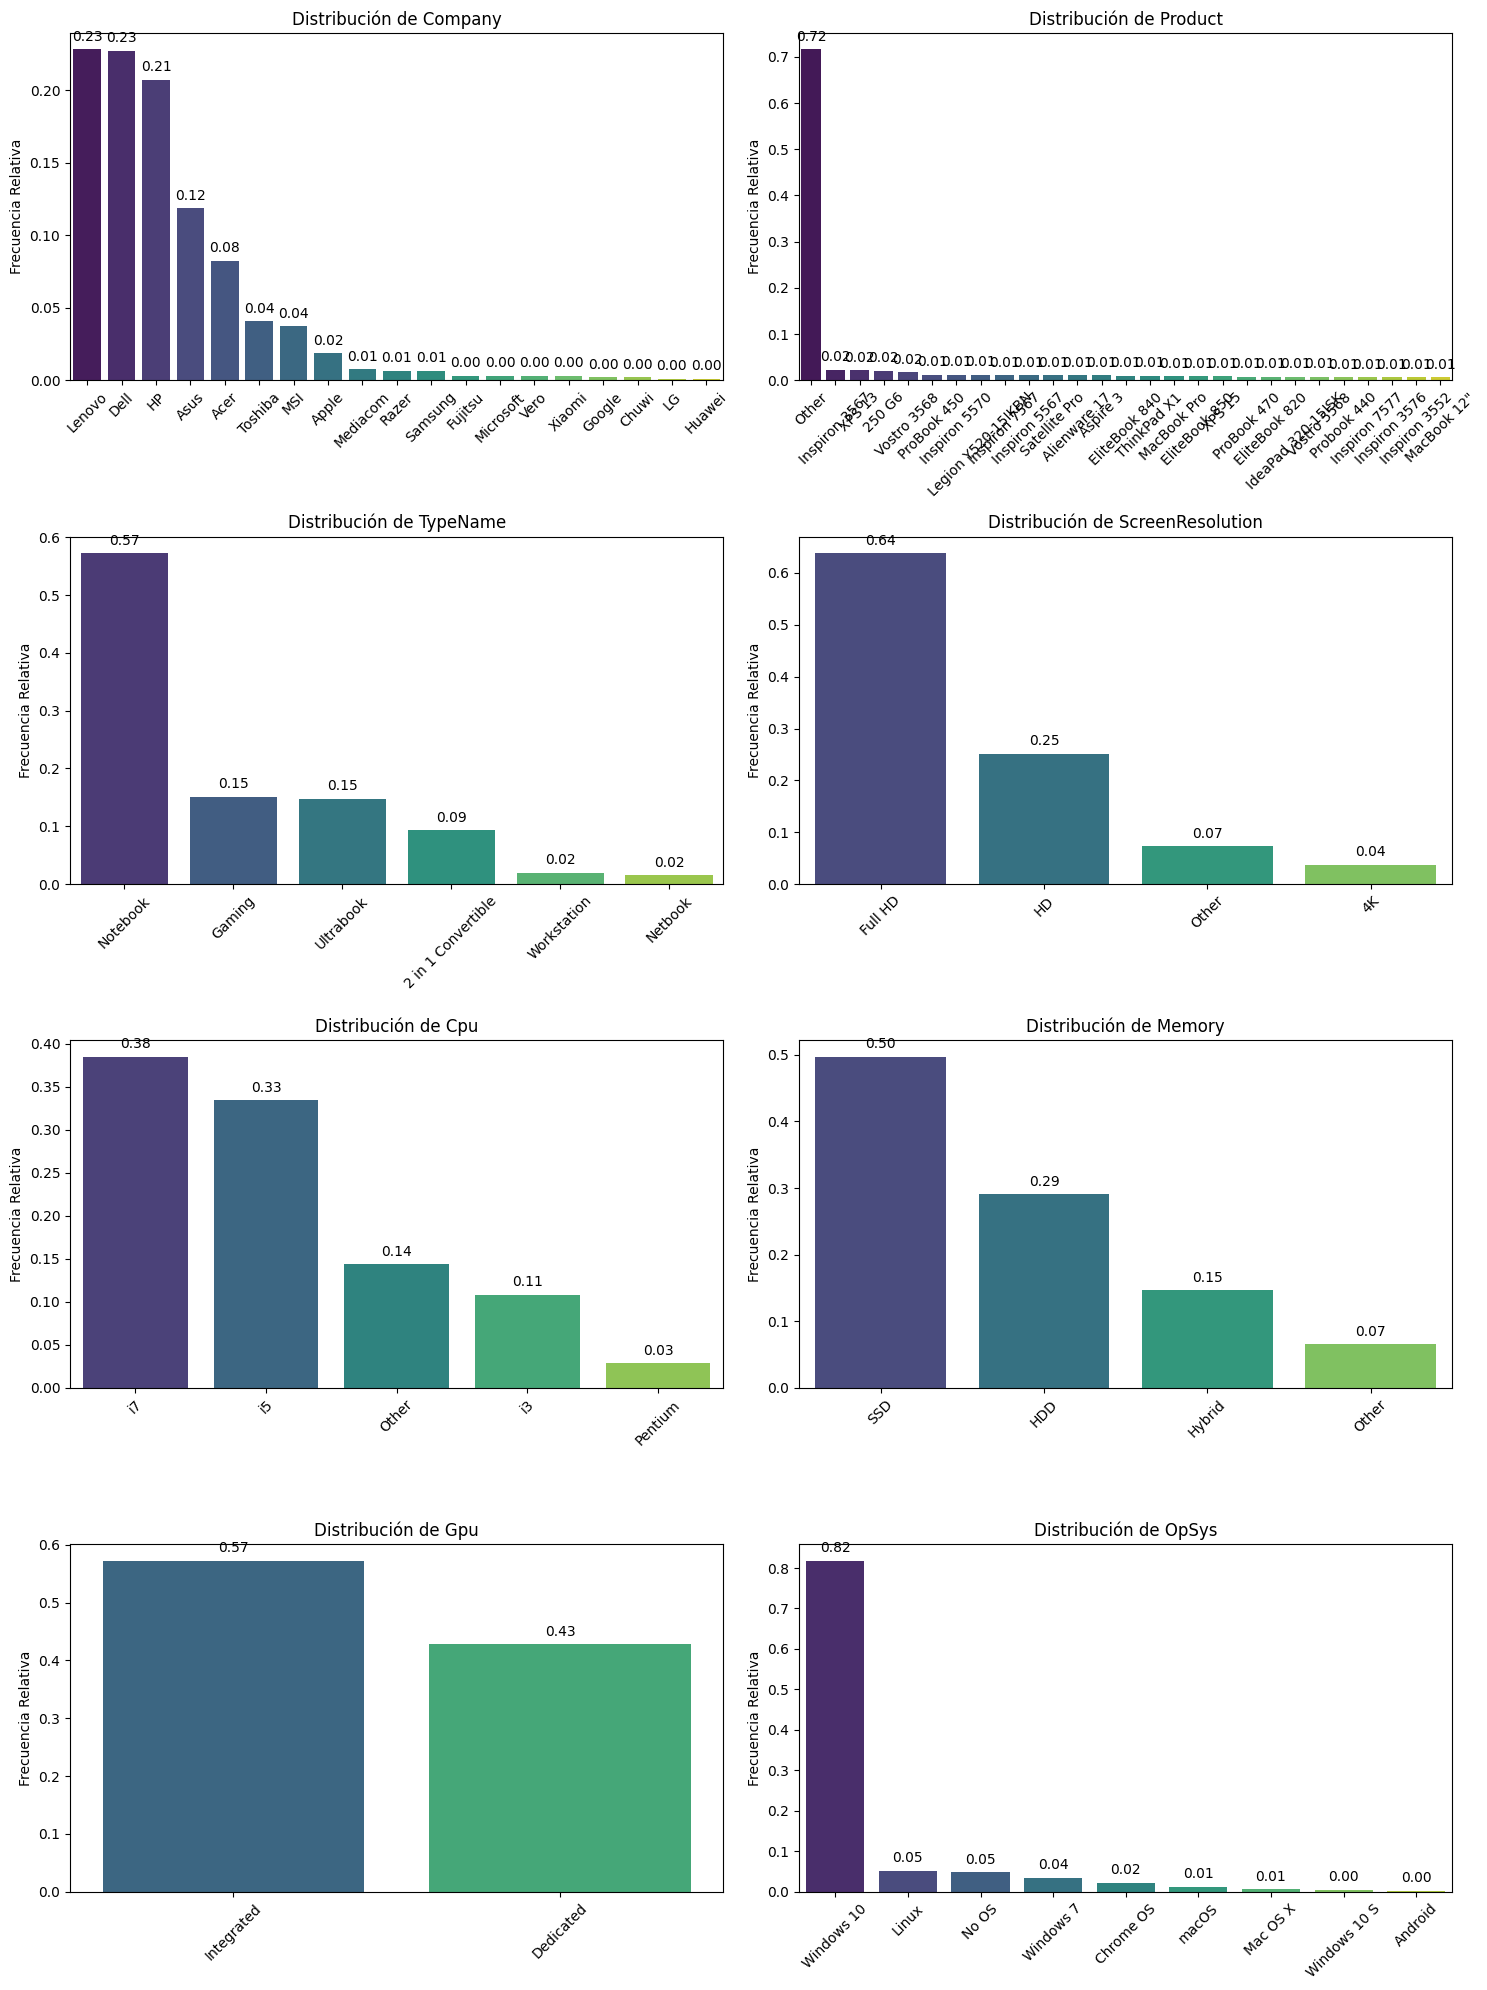

In [35]:
bt.pinta_distribucion_categoricas(df, features_cat, relativa = True, mostrar_valores = True)

Realizaremos el análisis ANOVA en todas estas columnas de datos. La columna 'Product' la tendremos en cuenta ya que esta columna contiene nombres de productos únicos que no son útiles para realizar una prueba ANOVA.

In [36]:
from scipy.stats import f_oneway

# Nombre de la categoría que deseas analizar
target_category = "Company"

if df[target_category].dtype == 'O' and target_category != 'id' and target_category != 'Product':
    categories = df[target_category].unique()  # Obtener las categorías únicas
    print(f"Variable categórica: {target_category}")
    # Crear una lista vacía para almacenar los grupos de datos
    group_data = []
    for category in categories:
        print(f"ANALIZANDO LA CATEGORÍA: {category}")
        # Obtener los datos de precios para la categoría actual
        category_data = df[df[target_category] == category]['Price_euros'].values.tolist()
        group_data.append(category_data)  # Agregar los datos de precios a la lista de grupos
    # Realizar la prueba ANOVA para todos los grupos
    f_statistic, p_value = f_oneway(*group_data)
    print(f"   F-statistic: {f_statistic}")
    print(f"   p-value: {p_value}")
    if p_value < 0.05:
        print("   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.")
    else:
        print("   No se puede rechazar la hipótesis nula: no hay diferencias significativas entre los grupos.")


Variable categórica: Company
ANALIZANDO LA CATEGORÍA: Dell
ANALIZANDO LA CATEGORÍA: Asus
ANALIZANDO LA CATEGORÍA: Toshiba
ANALIZANDO LA CATEGORÍA: MSI
ANALIZANDO LA CATEGORÍA: HP
ANALIZANDO LA CATEGORÍA: Lenovo
ANALIZANDO LA CATEGORÍA: Acer
ANALIZANDO LA CATEGORÍA: Apple
ANALIZANDO LA CATEGORÍA: Fujitsu
ANALIZANDO LA CATEGORÍA: Mediacom
ANALIZANDO LA CATEGORÍA: Razer
ANALIZANDO LA CATEGORÍA: Samsung
ANALIZANDO LA CATEGORÍA: LG
ANALIZANDO LA CATEGORÍA: Microsoft
ANALIZANDO LA CATEGORÍA: Vero
ANALIZANDO LA CATEGORÍA: Google
ANALIZANDO LA CATEGORÍA: Huawei
ANALIZANDO LA CATEGORÍA: Xiaomi
ANALIZANDO LA CATEGORÍA: Chuwi
   F-statistic: 10.558083134034037
   p-value: 1.601814230941227e-27
   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.


In [37]:
from scipy.stats import f_oneway

# Nombre de la categoría que deseas analizar
target_category = "TypeName"

if df[target_category].dtype == 'O' and target_category != 'id' and target_category != 'Product':
    categories = df[target_category].unique()  # Obtener las categorías únicas
    print(f"Variable categórica: {target_category}")
    # Crear una lista vacía para almacenar los grupos de datos
    group_data = []
    for category in categories:
        print(f"ANALIZANDO LA CATEGORÍA: {category}")
        # Obtener los datos de precios para la categoría actual
        category_data = df[df[target_category] == category]['Price_euros'].values.tolist()
        group_data.append(category_data)  # Agregar los datos de precios a la lista de grupos
    # Realizar la prueba ANOVA para todos los grupos
    f_statistic, p_value = f_oneway(*group_data)
    print(f"   F-statistic: {f_statistic}")
    print(f"   p-value: {p_value}")
    if p_value < 0.05:
        print("   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.")
    else:
        print("   No se puede rechazar la hipótesis nula: no hay diferencias significativas entre los grupos.")


Variable categórica: TypeName
ANALIZANDO LA CATEGORÍA: Notebook
ANALIZANDO LA CATEGORÍA: Gaming
ANALIZANDO LA CATEGORÍA: Ultrabook
ANALIZANDO LA CATEGORÍA: 2 in 1 Convertible
ANALIZANDO LA CATEGORÍA: Netbook
ANALIZANDO LA CATEGORÍA: Workstation
   F-statistic: 118.29991637097596
   p-value: 2.496534706156228e-96
   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.


In [38]:
from scipy.stats import f_oneway

# Nombre de la categoría que deseas analizar
target_category = "Cpu"

if df[target_category].dtype == 'O' and target_category != 'id' and target_category != 'Product':
    categories = df[target_category].unique()  # Obtener las categorías únicas
    print(f"Variable categórica: {target_category}")
    # Crear una lista vacía para almacenar los grupos de datos
    group_data = []
    for category in categories:
        print(f"ANALIZANDO LA CATEGORÍA: {category}")
        # Obtener los datos de precios para la categoría actual
        category_data = df[df[target_category] == category]['Price_euros'].values.tolist()
        group_data.append(category_data)  # Agregar los datos de precios a la lista de grupos
    # Realizar la prueba ANOVA para todos los grupos
    f_statistic, p_value = f_oneway(*group_data)
    print(f"   F-statistic: {f_statistic}")
    print(f"   p-value: {p_value}")
    if p_value < 0.05:
        print("   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.")
    else:
        print("   No se puede rechazar la hipótesis nula: no hay diferencias significativas entre los grupos.")

Variable categórica: Cpu
ANALIZANDO LA CATEGORÍA: i7
ANALIZANDO LA CATEGORÍA: Pentium
ANALIZANDO LA CATEGORÍA: i5
ANALIZANDO LA CATEGORÍA: i3
ANALIZANDO LA CATEGORÍA: Other
   F-statistic: 127.92889572506445
   p-value: 1.2785744676270252e-86
   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.


In [39]:
# Nombre de la categoría que deseas analizar
target_category = "Memory"

if df[target_category].dtype == 'O' and target_category != 'id' and target_category != 'Product':
    categories = df[target_category].unique()  # Obtener las categorías únicas
    print(f"Variable categórica: {target_category}")
    # Crear una lista vacía para almacenar los grupos de datos
    group_data = []
    for category in categories:
        print(f"ANALIZANDO LA CATEGORÍA: {category}")
        # Obtener los datos de precios para la categoría actual
        category_data = df[df[target_category] == category]['Price_euros'].values.tolist()
        group_data.append(category_data)  # Agregar los datos de precios a la lista de grupos
    # Realizar la prueba ANOVA para todos los grupos
    f_statistic, p_value = f_oneway(*group_data)
    print(f"   F-statistic: {f_statistic}")
    print(f"   p-value: {p_value}")
    if p_value < 0.05:
        print("   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.")
    else:
        print("   No se puede rechazar la hipótesis nula: no hay diferencias significativas entre los grupos.")

Variable categórica: Memory
ANALIZANDO LA CATEGORÍA: HDD
ANALIZANDO LA CATEGORÍA: SSD
ANALIZANDO LA CATEGORÍA: Hybrid
ANALIZANDO LA CATEGORÍA: Other
   F-statistic: 109.73333812128953
   p-value: 1.2543392832442183e-60
   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.


In [40]:
# Nombre de la categoría que deseas analizar
target_category = "Gpu"

if df[target_category].dtype == 'O' and target_category != 'id' and target_category != 'Product':
    categories = df[target_category].unique()  # Obtener las categorías únicas
    print(f"Variable categórica: {target_category}")
    # Crear una lista vacía para almacenar los grupos de datos
    group_data = []
    for category in categories:
        print(f"ANALIZANDO LA CATEGORÍA: {category}")
        # Obtener los datos de precios para la categoría actual
        category_data = df[df[target_category] == category]['Price_euros'].values.tolist()
        group_data.append(category_data)  # Agregar los datos de precios a la lista de grupos
    # Realizar la prueba ANOVA para todos los grupos
    f_statistic, p_value = f_oneway(*group_data)
    print(f"   F-statistic: {f_statistic}")
    print(f"   p-value: {p_value}")
    if p_value < 0.05:
        print("   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.")
    else:
        print("   No se puede rechazar la hipótesis nula: no hay diferencias significativas entre los grupos.")

Variable categórica: Gpu
ANALIZANDO LA CATEGORÍA: Dedicated
ANALIZANDO LA CATEGORÍA: Integrated
   F-statistic: 46.40608972955114
   p-value: 1.7459120926934814e-11
   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.


In [41]:
# Nombre de la categoría que deseas analizar
target_category = "OpSys"

if df[target_category].dtype == 'O' and target_category != 'id' and target_category != 'Product':
    categories = df[target_category].unique()  # Obtener las categorías únicas
    print(f"Variable categórica: {target_category}")
    # Crear una lista vacía para almacenar los grupos de datos
    group_data = []
    for category in categories:
        print(f"ANALIZANDO LA CATEGORÍA: {category}")
        # Obtener los datos de precios para la categoría actual
        category_data = df[df[target_category] == category]['Price_euros'].values.tolist()
        group_data.append(category_data)  # Agregar los datos de precios a la lista de grupos
    # Realizar la prueba ANOVA para todos los grupos
    f_statistic, p_value = f_oneway(*group_data)
    print(f"   F-statistic: {f_statistic}")
    print(f"   p-value: {p_value}")
    if p_value < 0.05:
        print("   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.")
    else:
        print("   No se puede rechazar la hipótesis nula: no hay diferencias significativas entre los grupos.")

Variable categórica: OpSys
ANALIZANDO LA CATEGORÍA: Windows 10
ANALIZANDO LA CATEGORÍA: Windows 7
ANALIZANDO LA CATEGORÍA: Linux
ANALIZANDO LA CATEGORÍA: Chrome OS
ANALIZANDO LA CATEGORÍA: No OS
ANALIZANDO LA CATEGORÍA: Mac OS X
ANALIZANDO LA CATEGORÍA: Windows 10 S
ANALIZANDO LA CATEGORÍA: macOS
ANALIZANDO LA CATEGORÍA: Android
   F-statistic: 13.933932263978484
   p-value: 3.2629365755143085e-19
   Se rechaza la hipótesis nula: hay diferencias significativas entre al menos dos grupos.


En resumen, todas las variables categóricas son importantes. Nos tenemos que quedar todas y no podemos eliminar columnas.

### Features numéricas

In [42]:
#features_num = ["Inches", "laptop_ID"]

In [43]:
features_num = df.select_dtypes(include='number').columns.to_list()
features_num.remove('Price_euros')

In [44]:
features_num

['laptop_ID', 'Inches', 'Ram', 'Weight']

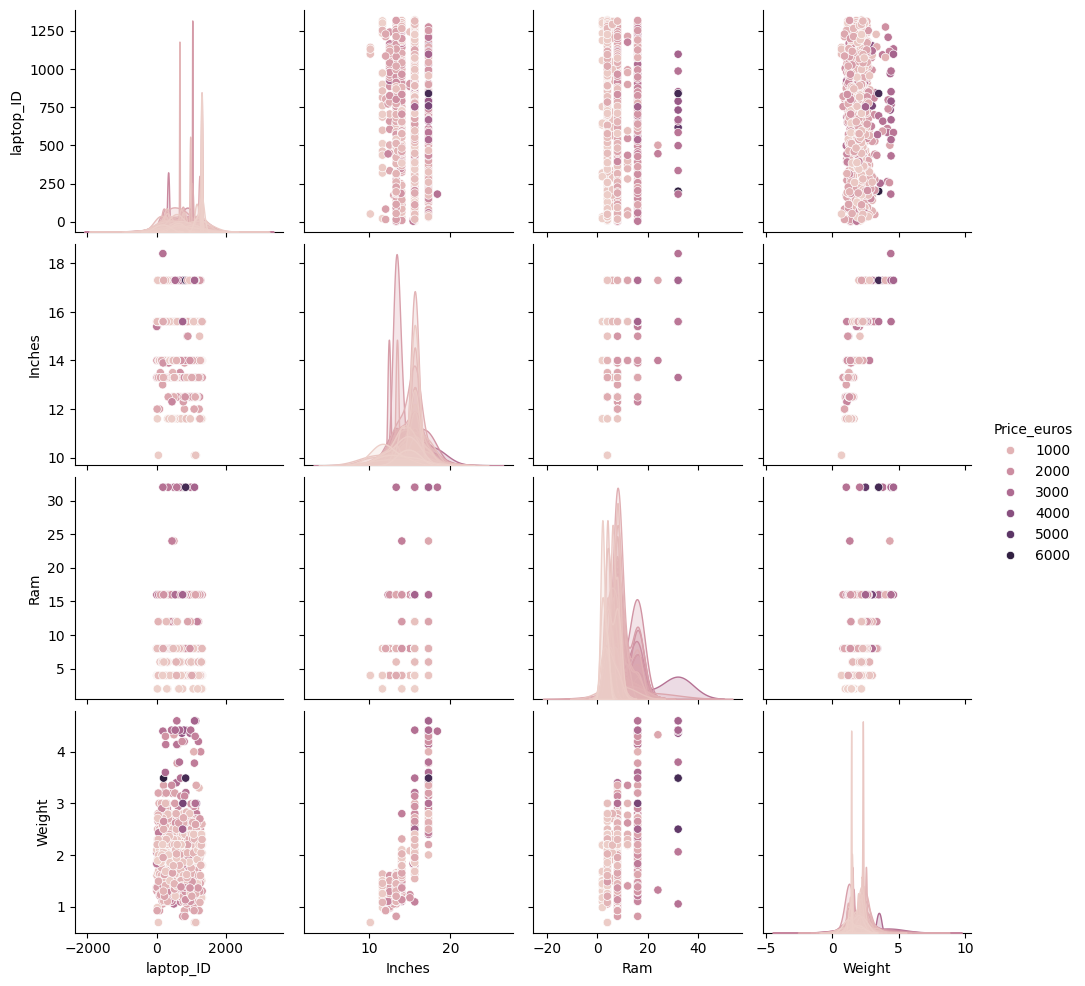

In [45]:
sns.pairplot(df[features_num + [target]], hue = target)

Vemos diferenciaciones en todas las variables, de modo que emplearíamos todas en nuestro modelo.

In [46]:
df[features_num].describe()

,laptop_ID,Inches,Ram,Weight
count,912.000000,912.000000,912.000000,912.000000
mean,666.192982,15.011404,8.188596,2.032112
std,384.873846,1.411744,4.899827,0.653772
min,1.000000,10.100000,2.000000,0.690000
25%,330.500000,14.000000,4.000000,1.500000
50%,673.500000,15.600000,8.000000,2.040000
75%,998.500000,15.600000,8.000000,2.300000
max,1320.000000,18.400000,32.000000,4.600000


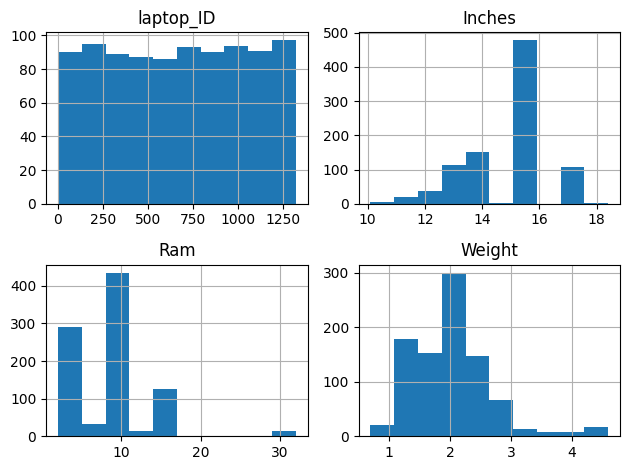

In [47]:
df[features_num].hist()
plt.tight_layout();

En Inches habrá que escalar ya que son rangos muy diversos. Una transformación tipo logarítmica no le vendría nada mal para "normalizarla" un poco

In [48]:
df['Inches'].value_counts()

Inches
15.6    474
14.0    143
13.3    111
17.3    108
12.5     28
11.6     21
12.0      6
10.1      4
13.9      4
15.4      3
15.0      3
13.5      3
12.3      2
13.0      1
18.4      1
Name: count, dtype: int64

In [49]:
# Guardamos el DataFrame en un archivo CSV
df.to_csv('train_limpio.csv', index=False)


In [50]:
# Guardamos el DataFrame en un archivo CSV
df_test.to_csv('test_limpio.csv', index=False)